# How to implement weak measurement in IBM Qiskit?
-----

# Introduction

An essential characteristic of quantum measurements is the disturbance they impose on the system, known as quantum back-action. Traditional von Neumann orthogonal projection measurements are irreversible, as they completely collapse the system's state into its eigenstate. In contrast, weak measurement minimizes this disturbance by reducing the interaction involved in the measurement process. There is a trade-off between information gain and system disturbance in quantum weak measurement: weaker measurements yield less information while causing less disruption.


In this tutorial, I will explain how to implement two types of weak measurement operators in IBM Qiskit: 
1) Complete weak measurement operators. 
2) Partial weak measurement operators. 

These operators have been experimentally demonstrated in photonic architecture [1,2]. Here, I will guide you on implementing them from home using IBM Qiskit.

Let us define the system state as

$$
|\psi_{\text{in}}\rangle = \alpha |0\rangle + \beta |1\rangle,
$$

or, equivalently, the density matrix representation as

$$
\rho_{\text{in}} = \begin{bmatrix} \alpha^2 & \alpha \beta \\ \alpha \beta & \beta^2 \end{bmatrix},
$$

where $\alpha^2 + \beta^2 = 1$. For simplicity, we will assume that both $\alpha$ and $\beta$ are real numbers.



  # 1. Complete weak measurement
----

   ## 1.1 Mathematical derivation

The complete weak measurement operators are defind as [1]:
$$
    M_0= \begin{bmatrix} \cos{\frac{\theta}{2}}&0\\0&\sin{\frac{\theta}{2}} \end{bmatrix} , \  
    {M}_1= \begin{bmatrix} \sin{\frac{\theta}{2}}&0\\0&\cos{\frac{\theta}{2}} \end{bmatrix}, 
$$
where $\theta \in [0, \frac{\pi}{2}]$ and ${M_0}^\dagger{M_0}+{M_1}^\dagger{M_1}=I$. When $\theta = \frac{\pi}{2}$, the measurement strength is zero, resulting in no effective measurement. Conversely, when $\theta = 0$, the measurement strength is maximized, leading to projective measurement that collapses the system state to its eigenstates. For $0 < \theta < \frac{\pi}{2}$, we perform weak measurements, allowing us to adjust $\theta$ to balance the information gain with the disturbance caused by the measurement.


After employing the complete weak measurement, if the result corresponding to $M_0$ is observed, the unnormalized system state becomes 
$$
    \rho_{M_0}=M_0 \rho_{\text{in}} M_0^{\dagger}=\begin{bmatrix} \alpha^2 \cos^2{\frac{\theta}{2}}&\alpha \beta \cos{\frac{\theta}{2}}\sin{\frac{\theta}{2}} \\\ \alpha \beta \cos{\frac{\theta}{2}}\sin{\frac{\theta}{2}}&\beta^2 \sin^2{\frac{\theta}{2}} \end{bmatrix}. 
$$

The probability of this outcome is given by 
$$
    g_0=\text{trace}(\rho_{M_0})=\alpha^2 \cos^2{\frac{\theta}{2}}+\beta^2 \sin^2{\frac{\theta}{2}}.
$$

Consequently, the normalized state can be expressed as 
$$
    \overline{\rho}_{M_0}=\frac{ \rho_{M_0}}{g_0}.
$$

With the same process, the normalized state corresponding to measurement operator $M_1$ is given as
$$
    \overline{\rho}_{M_1}=\frac{M_1 \rho_{\text{in}} M_1^{\dagger}}{g_1}=\frac{1}{\alpha^2 \sin^2{\frac{\theta}{2}}+\beta^2 \cos^2{\frac{\theta}{2}}}\begin{bmatrix} \alpha^2 \sin^2{\frac{\theta}{2}}&\alpha \beta \cos{\frac{\theta}{2}}\sin{\frac{\theta}{2}} \\\ \alpha \beta \cos{\frac{\theta}{2}}\sin{\frac{\theta}{2}}&\beta^2 \cos^2{\frac{\theta}{2}} \end{bmatrix}. 
$$

## 1.2 Python Simulation
First, let's check each outcome corresponds to $M_0$ and $M_1$, with the follwoing Python code:



Initial state:


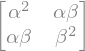

Resulting state corresponds to M0:


<IPython.core.display.Math object>

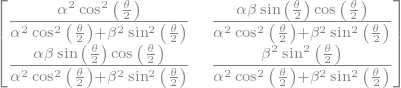

Resulting state correponds to M1:


<IPython.core.display.Math object>

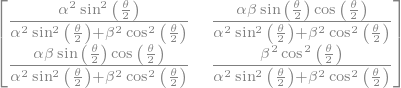

In [1]:
import sympy as sp
import numpy as np
from IPython.display import display, Math

# Define the symbols
alpha = sp.Symbol('alpha', latex=r'\alpha')
beta = sp.Symbol('beta', latex=r'\beta')
theta = sp.Symbol('theta', latex=r'\theta')
a, b, th = sp.symbols('alpha beta theta')


# Define the state vectors
H = sp.Matrix([1, 0])  # |0>
V = sp.Matrix([0, 1])  # |1>

# Create the vector
si = np.array([a, b])

# Compute the outer product
rin = np.outer(si, si)

# Convert the NumPy array to a SymPy Matrix
rsi_sympy = sp.Matrix(rin)

# Pretty print the resulting matrix
print("Initial state:")
sp.init_printing(use_unicode=True)
display(rsi_sympy)

# Define the Complete measurement operators
m0 = sp.Matrix([[sp.cos(th/2), 0],
                 [0, sp.sin(th/2)]])

m1 = sp.Matrix([[sp.sin(th/2), 0],
                 [0, sp.cos(th/2)]])

# Compute \rho_M0
rm0 = m0 * rin * m0.T
g0 = rm0.trace()
rmn0 = rm0 / g0

# Compute \rho_M1
rm1 = m1 * rin * m1.T
g1 = rm1.trace()
rmn1 = rm1 / g1

# Display the result
print("Resulting state corresponds to M0:")
display(Math(r'\rho_{M_0}='))
sp.init_printing(use_unicode=True)
display(rmn0)

print("Resulting state correponds to M1:")
display(Math(r'\rho_{M_1}='))
sp.init_printing(use_unicode=True)
display(rmn1)

## 1.3 Qiskit simulation

To design the quantum circuit for the complete weak measurement, we introduce an ancilla qubit to the system and utilize a rotation on the ancilla qubit [3]. The mathematical formula for Qiskit's rotation gate is given as: 
$$
    U(\theta,\phi,\lambda)=\left[ \begin{array}{cc}
\cos({\frac{\theta}{2}})  & -e^{i\lambda}\sin({\frac{\theta}{2}}) \\ 
e^{i\phi}\sin({\frac{\theta}{2}})  & e^{i(\phi+\lambda)}\cos({\frac{\theta}{2}})  \end{array}
\right].
$$


To implement the complete weak measurement using Qiskit, the rotation gate parameters should be set as $\theta$ (same as the measurement strength of the measurement operators), and $\phi = \lambda = 0$. After employing the rotation on the ancilla qubit, a CNOT gate is used, with the system state as the control qubit and the ancilla qubit as the target qubit. Finally, a measurement is performed on the ancilla qubit.
The ancilla's measurement result determines the state evolution: a result of 0 indicates that the weak measurement operator $M_0$ has been applied, while a result of 1 corresponds to the application of $M_1$. 

We will compare the results from Python and Qiskit at the end. Please set the desired initial state parameters $\alpha$ and $\beta$, as well as the measurement strength $\theta$, here: 


In [2]:
alpha = np.sqrt(0.4)  
beta = np.sqrt(1 - alpha**2) 
theta =0.5

specific_values = {a: alpha, b: beta, th: theta}

C:\Users\Sajede Harraz\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


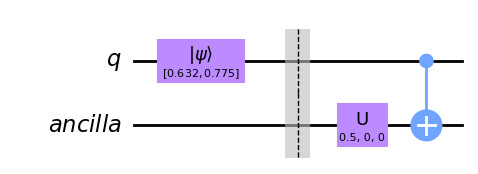

In [3]:
from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.quantum_info import DensityMatrix, partial_trace
import matplotlib.pyplot as plt

q = QuantumRegister(1, 'q')
anc = QuantumRegister(1, 'ancilla')
qc = QuantumCircuit(q, anc)

# Initialize the state vector
initial_state = [alpha, beta]

# Initialize the qubit
qc.initialize(initial_state, 0)
qc.barrier()
# Employing measurement
qc.u(theta,0,0,anc[0])
qc.cx(0, 1)
qc.draw('mpl')

Now we execute the circuit using the "statevector_simulator":




Mathematical result corresponds to M0:

⎡0.910913360948403  0.284868758894491 ⎤
⎢                                     ⎥
⎣0.284868758894491  0.0890866390515971⎦


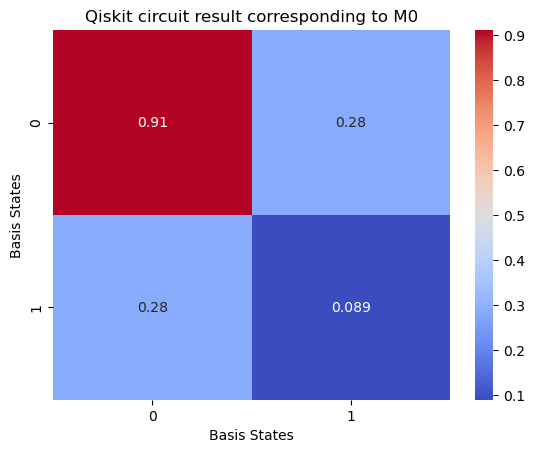

In [4]:
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
statevector = result.get_statevector()

# Create the full density matrix
full_dm = DensityMatrix(statevector)

# Function to get the reduced density matrix when ancilla is 0
def get_reduced_dm_ancilla_0(full_dm):
    dims = full_dm.dims()
    m0 = np.array([     #The operator to measure the ancilla qubit in state 0
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ])
    projector = DensityMatrix(m0)    
    projected_dm = DensityMatrix(projector.data @ full_dm.data) 
    reduced_dm = partial_trace(projected_dm, [1])
    # Normalize the reduced density matrix
    reduced_dm = reduced_dm / reduced_dm.trace()    
    return reduced_dm

# Get the reduced density matrix
reduced_dm0 = get_reduced_dm_ancilla_0(full_dm)
reduced_dm_values = reduced_dm0.data

# The Python simulation result:  
rmn0_evaluated = rmn0.subs(specific_values)
print("\nMathematical result corresponds to M0:\n")
sp.pprint(rmn0_evaluated)

import seaborn as sns

# Create a heatmap of the reduced density matrix
sns.heatmap(reduced_dm_values.real, annot=True, cmap='coolwarm', cbar=True)
plt.title('Qiskit circuit result corresponding to M0')
plt.xlabel('Basis States')
plt.ylabel('Basis States')
plt.show()


Mathematical result corresponds to M1:

⎡0.0416557102586254  0.19980118133153 ⎤
⎢                                     ⎥
⎣ 0.19980118133153   0.958344289741375⎦


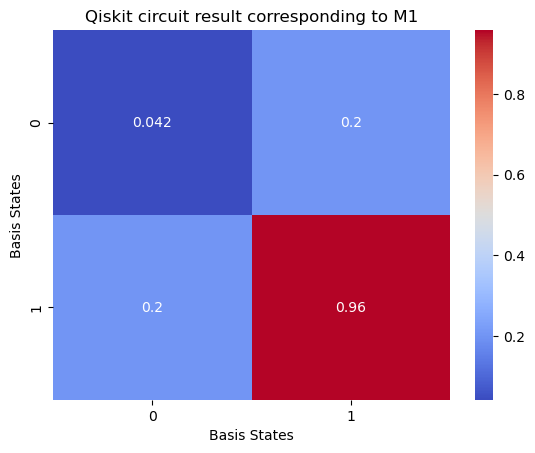

In [5]:
# Function to get the reduced density matrix when ancilla is 1
def get_reduced_dm_ancilla_1(full_dm):
    dims = full_dm.dims()
    m1 = np.array([     #The operator to measure the ancilla qubit in state 1 
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    projector = DensityMatrix(m1)    
    projected_dm = DensityMatrix(projector.data @ full_dm.data) 
    reduced_dm = partial_trace(projected_dm, [1])
    # Normalize the reduced density matrix
    reduced_dm = reduced_dm / reduced_dm.trace()  
    return reduced_dm

# Get the reduced density matrix
reduced_dm1 = get_reduced_dm_ancilla_1(full_dm)
reduced_dm_values = reduced_dm1.data

# The Python simulation result:
rmn1_evaluated = rmn1.subs(specific_values) 
print("\nMathematical result corresponds to M1:\n")
sp.pprint(rmn1_evaluated)

import seaborn as sns

# Create a heatmap of the reduced density matrix
sns.heatmap(reduced_dm_values.real, annot=True, cmap='coolwarm', cbar=True)
plt.title('Qiskit circuit result corresponding to M1')
plt.xlabel('Basis States')
plt.ylabel('Basis States')
plt.show()


# 2. Partial weak measurement
----

## 2.1 Mathematical derivation

The partial weak measurement operators are defined as [2]
$$
    M= \begin{bmatrix} \sqrt{1-p}&0\\0&1 \end{bmatrix} , \  
    \overline{M}= \begin{bmatrix} \sqrt{p}&0\\0&0 \end{bmatrix}, 
$$
where, ${M}^\dagger{M}+{\overline{M}}^\dagger\overline{M}=I $ and  $p\in[0,1]$ denotes the strength of the weak measurement. In this type of weak measurement, the results from $M$ are typically retained, while the outcomes of $\overline{M}$ are discarded.

If the result of $M$ is obtained, the resulting state is represented as 
$$
    \rho_{M}=M \rho_{\text{in}} M^{\dagger}=\begin{bmatrix} \alpha^2 (1-p)&\alpha \beta \sqrt{1-p} \\\ \alpha \beta  \sqrt{1-p}&\beta^2  \end{bmatrix}. 
$$

The probability of obtaining the result corresponding to $M$ is
$$
    g_M=\text{trace}(\rho_{M})=\alpha^2 (1-p)+\beta^2.
$$

Thus, the normalized state can be expressed as 
$$
    \overline{\rho}_{M}=\frac{ \rho_{M}}{g_M}.
$$

Conversely, if the result corresponding to $\overline{M}$ is observed, the resulting system state becomes:
$$
    \rho_{\overline{M}}=\overline{M} \rho_{\text{in}} \overline{M}^{\dagger}=\begin{bmatrix} \alpha^2 p& 0 \\\ 0&0  \end{bmatrix}. 
$$

The probability of this outcome is given by 
$$
    g_\overline{M}=\text{trace}(\rho_{\overline{M}})=\alpha^2 p.
$$

Therefore, the normalized state is
$$
    \overline{\rho}_{\overline{M}}=\frac{ \rho_{\overline{M}}}{g_\overline{M}}= \begin{bmatrix} 1& 0 \\\ 0&0  \end{bmatrix}. 
$$

As shown, the measurement operator $\overline{M}$ causes the system state to collapse to $|0\rangle$. This is why the result from this operator is discarded, and only the outcome from $M$ is retained.


## 2.2 Python Simulation
Now, let's check each outcome corresponds to $M$ and $\overline{M}$, with the follwoing Python code:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

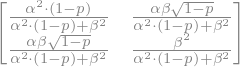

<IPython.core.display.Math object>

<IPython.core.display.Math object>

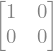

In [6]:
p = sp.symbols('p')

# Define the matrices M and Mb
M = sp.Matrix([[sp.sqrt(1 - p), 0], [0, 1]])
Mb = sp.Matrix([[sp.sqrt(p), 0], [0, 0]])


# Compute \rho_M0
rm = M * rin * M.T
g = rm.trace()
rM = rm / g

# Compute \rho_M1
rmb = Mb * rin * Mb.T
gb = rmb.trace()
rMb = rmb / gb

# Display the result
display(Math(r'Resulting \ state \ correponds \ to \ {M}:'))
display(Math(r'\rho_{M}='))
sp.init_printing(use_unicode=True)
display(rM)

display(Math(r'Resulting \ state \ correponds \ to \ \overline{M}:'))
display(Math(r'\rho_{\overline{M}}='))
sp.init_printing(use_unicode=True)
display(rMb)

## 2.3 Qiskit simulation

To design the quantum circuit for partial weak measurement, we introduce an ancilla qubit into the circuit and utilize a controlled rotation, with the system qubit acting as the control qubit and the ancilla qubit as the target qubit [4]. The specific mathematical representation of Qiskit's controlled rotation gate is given by 
$$
    C_u(\theta,\phi,\lambda, \gamma)=\begin{bmatrix}
        1&0&0&0\\0&e^{-i(\phi+\lambda)/2}\cos(\theta/2)&0&-e^{-i(\phi-\lambda)/2}\sin(\theta/2)\\
       0&0&1&0\\0&e^{i(\phi-\lambda)/2}\sin(\theta/2)&0&e^{i(\phi+\lambda)/2}\cos(\theta/2)
    \end{bmatrix}.
$$

In order to implement the partial weak measurement, the controlled rotation gate parameters, should be set as $\theta=2\arctan(\frac{\sqrt{p}}{1-\sqrt{1-p}}) \text{ and } \phi=\lambda=\gamma=0 $, where $p$ is the strength of the weak measurement.
After the controlled rotation with specified parameters, a measurement is performed on the ancilla qubit. The ancilla's measurement result determines the state evolution: a result of 0 indicates that the weak measurement operator $M$ has been applied, while a result of 1 corresponds to the application of $\overline{M}$. 

We will compare the results from Python and Qiskit at the end. Please set the desired initial state parameters $\alpha$ and $\beta$, as well as the measurement strength $p$, here: 


In [7]:
alpha = np.sqrt(0.7)  
beta = np.sqrt(1 - alpha**2) 
p_value =0.8 #Measurement strength

specific_values = {a: alpha, b: beta, p: p_value}

C:\Users\Sajede Harraz\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


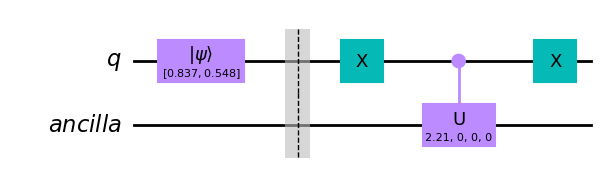

In [8]:
qc = QuantumCircuit(q, anc)

# Initialize the state vector
initial_state = [alpha, beta]

# Initialize the qubit
qc.initialize(initial_state, 0)
qc.barrier()
# Employing measurement
qc.x(q[0])
t=2*np.arctan((np.sqrt(p_value))/np.sqrt(1-p_value));
#t=2*y;
qc.cu(t, 0, 0, 0, q[0], anc[0])
qc.x(q[0])
qc.draw('mpl')

Now we execute the circuit using the "statevector_simulator":


Mathematical result corresponds to M:

⎡0.318181818181818   0.4657704893618 ⎤
⎢                                    ⎥
⎣ 0.4657704893618   0.681818181818182⎦


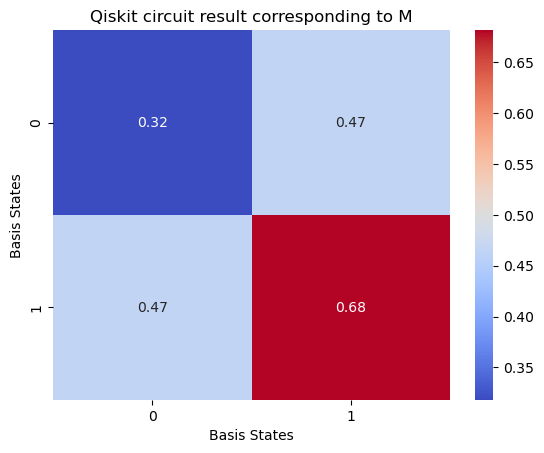

In [9]:
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
statevector = result.get_statevector()

# Create the full density matrix
full_dm = DensityMatrix(statevector)

# Function to get the reduced density matrix when ancilla is 0
def get_reduced_dm_ancilla_0(full_dm):
    dims = full_dm.dims()
    m0 = np.array([     #The operator to measure the ancilla qubit in state 0
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ])
    projector = DensityMatrix(m0)    
    projected_dm = DensityMatrix(projector.data @ full_dm.data) 
    reduced_dm = partial_trace(projected_dm, [1])
    # Normalize the reduced density matrix
    reduced_dm = reduced_dm / reduced_dm.trace()    
    return reduced_dm

# Get the reduced density matrix
reduced_dm0 = get_reduced_dm_ancilla_0(full_dm)
reduced_dm_values = reduced_dm0.data

# The Python simulation result:  
rm_evaluated = rM.subs(specific_values)
print("\nMathematical result corresponds to M:\n")
sp.pprint(rm_evaluated)

import seaborn as sns

# Create a heatmap of the reduced density matrix
sns.heatmap(reduced_dm_values.real, annot=True, cmap='coolwarm', cbar=True)
plt.title('Qiskit circuit result corresponding to M')
plt.xlabel('Basis States')
plt.ylabel('Basis States')
plt.show()

<IPython.core.display.Math object>

⎡1  0⎤
⎢    ⎥
⎣0  0⎦


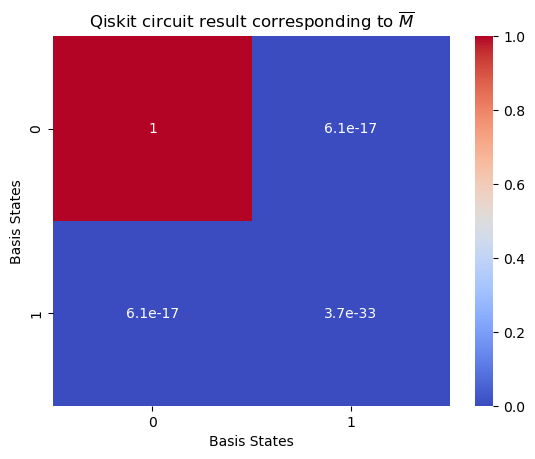

In [10]:
# Function to get the reduced density matrix when ancilla is 1
def get_reduced_dm_ancilla_1(full_dm):
    dims = full_dm.dims()
    m1 = np.array([     #The operator to measure the ancilla qubit in state 1 
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    projector = DensityMatrix(m1)    
    projected_dm = DensityMatrix(projector.data @ full_dm.data) 
    reduced_dm = partial_trace(projected_dm, [1])
    # Normalize the reduced density matrix
    reduced_dm = reduced_dm / reduced_dm.trace()  
    return reduced_dm

# Get the reduced density matrix
reduced_dm1 = get_reduced_dm_ancilla_1(full_dm)
reduced_dm_values = reduced_dm1.data

# The Python simulation result:
rmb_evaluated = rMb.subs(specific_values) 
display(Math(r'Mathematical\ result\ corresponds\ to\ \overline{M}:'))

sp.pprint(rmb_evaluated)

import seaborn as sns

# Create a heatmap of the reduced density matrix
sns.heatmap(reduced_dm_values.real, annot=True, cmap='coolwarm', cbar=True)
plt.title('Qiskit circuit result corresponding to $\\overline{M}$')
plt.xlabel('Basis States')
plt.ylabel('Basis States')
plt.show()

# References

[1] Gillett, G. G., et al. "Experimental feedback control of quantum systems using weak measurements." Physical review letters 104.8 (2010): 080503.

[2] Kim, Yong-Su, et al. "Protecting entanglement from decoherence using weak measurement and quantum measurement reversal." Nature Physics 8.2 (2012): 117-120.

[3] Sajede, Harraz, and Shuang Cong. "Efficient entanglement enhancement of partially entangled pairs." Physica Scripta 99.8 (2024): 085110.

[4] Sajede, Harraz, Wang Yueyan, and Shuang Cong. "Unilateral protection scheme for N-qubit GHZ states against decoherence: a resource-efficient approach." The Journal of Supercomputing (2024): 1-17.